This notebook will demonstrate a simple compile and deployment workflow using a ResNet50 pre-trained image recognizer with sample input images

First, we define all of our parameters that will be used in the notebook

This notebook will require the "Tensorflow 2.1 Python 3.6 CPU Optimized" Kernel.  Other kernels will likely NOT work. 

In [ ]:
# Setup our Sagemaker configuration tunables
aws_region = 'us-east-1'
aws_s3_folder = "DEMO-Sagemaker-Edge"

# We will use the ResNet50 image recognition model via Keras framework
model_framework = 'keras'
model_basename = 'resnet50'
model_name = model_framework + "-" + model_basename + "-image-recognizer"
packaged_model_name = model_framework + "-" + model_basename + "-model"
packaged_model_version = "1.0"

# Decoder classification json specific to ResNet50...
resnet50_class_list_path = './model/imagenet_class_index.json'

# Input images WxH is 224x224 and are color images (so 3 channels)
image_size_w       = 224
image_size_h       = 224
image_num_channels = 3

# Our Pelion Edge Gateway is a Nvidia Jetson Xavier
target_device = 'jetson_xavier'

# Set our Pelion API Configuration Here
api_key = 'INSERT_YOUR_PELION_APPLICATION_KEY_HERE'
device_id = 'INSERT_YOUR_PELION_XAVIER_EDGE_SAGE_PT_DEVICEID_HERE' # Pelion Device ID of our Sagemaker Edge Agent PT device under our Pelion Edge gateway
endpoint_api = 'api.' + aws_region + '.mbedcloud.com'              # This is optional and the default
async_response_sec = 0.25                                          # Pelion long polling tunable. Typically no need to change

Next we import some additional packages into our python environment... including the pelion/sagemaker controller package

In [ ]:
# Lets install some image utilities
! pip install ipympl

# Core imports for the notebook
import numpy as np 
import tensorflow as tf
import time
import os
import json

# We will use the ResNet50 Keras model, pre-trained with imagenet weights...
from tensorflow.keras.applications import ResNet50

# ResNet50 helpers used specifically with our selected pre-trained model
from tensorflow.keras.applications.resnet50 import preprocess_input

Next we import the Pelion Sagemaker Controller API... this has a notebook helper which will simplify our notebook.

In [ ]:
! pip install pelion_sagemaker_controller
from pelion_sagemaker_controller import pelion_sagemaker_controller

Next we allocate our notebook helper. This Helper will allocate a channel to my sagemaker PT device in Pelion and sync the S3 config info with our Sagemaker NB.

In [ ]:
my_notebook = pelion_sagemaker_controller.MyNotebook(api_key, device_id, endpoint_api, aws_s3_folder, async_response_sec)

Now... next we prepare our input images and upload them to S3 as preprocessed images for ResNet50 from Keras...

In [ ]:
# Input images directory in our notebook...
image_paths = './images'

# collect and prepare our images to analyze
print("")
print("Collecting images from: " + str(image_paths))
my_image_list = [os.path.join(image_paths,filename) for filename in os.listdir(image_paths) if os.path.isfile(image_paths + '/' + filename)]
my_image_list_length = len(my_image_list)

print("")
print("Input Image Files: " + json.dumps(my_image_list))

# read in the batch of images... then, preprocess_input() is ResNet50 specific
print("")
print("Pre-processing input image files...")
image_data = my_notebook.read_image_batch(my_image_list, image_size_h, image_size_w)
preprocessed_images_list = preprocess_input(image_data['array'])

# Display our initial images
print("")
print("Displaying Input Images:")
my_notebook.display_images(image_data['img'])

#
# Neo Sagemaker likes NCHW shapes for Keras models. 
# Our image set is in NHWC...
#
print("")
print("Input shape: " + str(preprocessed_images_list.shape))
print("Input dtype: " + str(preprocessed_images_list.dtype))
print("Input data length number of images: " + str(len(preprocessed_images_list)))

# ...so transpose() to NCHW format...  we have to do this because Neo requires a NCHW layer...
preprocessed_images_list = tf.transpose(preprocessed_images_list,[0, 3, 1, 2])

# Neo-compatible input tensor shape now!
print("")
print("Neo transposed Input shape: " + str(preprocessed_images_list.shape))
print("Neo transposed Input dtype: " + str(preprocessed_images_list.dtype))
print("Neo transposed Input data length number of images: " + str(len(preprocessed_images_list)))

# Save the preprocessed images, as the input tensor, to a single input file in S3
input_data_filename = 'preprocessed_images_' + str(time.time()) + '.input'
my_notebook.save_input_tensor_to_s3(preprocessed_images_list,input_data_filename)

Next, lets import a pre-trained Mobilenet v2 model via TF Hub...

In [ ]:
# Create the ResNet50 pre-trained model via Keras framework...
print("Allocating ResNet50 model")
resnet50_model = ResNet50(weights="imagenet", pooling="avg")
    
# Lets dump the model details... 
print(resnet50_model.summary())

Next, we compile up the model and package it for sending down to the edge agent on the gateway...

In [ ]:
# Next, lets record the input layer for the Neo-compatible input_shape for Keras-based models...
input_layer = resnet50_model.get_layer(index=0)

# Neo wants me to build out a specific input_shape (in NCHW per above...) for the compile() task...
neo_input_layer_shape = {}
neo_input_layer_shape[input_layer.name] = [my_image_list_length, image_num_channels, image_size_h, image_size_w]
neo_input_layer_shape = json.dumps(neo_input_layer_shape)
print("")
print("Neo expects this input_shape if compiling a Keras model: " + neo_input_layer_shape)

# Compile up for our target Pelion Edge Gateway platform type
print("")
print("Initiating Sagemaker Neo compile of " + model_name + "...")
job_name = my_notebook.compile_model(resnet50_model, target_device, model_basename, model_framework, neo_input_layer_shape)

# Package up and store the compiled model onto S3
print("")
print("Packaging up Neo-compiled model and placing in S3...")
model_package = my_notebook.package_model(packaged_model_name, packaged_model_version, job_name)

Next, we (re)load our model since we have just (re)compiled it and (re)packaged it...

In [ ]:
# pulled from package_model()
model_package = '{}-{}.tar.gz'.format(keras_packaged_model_name, keras_model_version)

# (re)load the newly compiled model...
print('Reloading Model: ' + model_name + " in package: " + model_package + '...')
print("")
my_notebook.pelion_api.pelion_reload_model(model_name,model_package)

# Poll every 5 sec to look for the reload() completion....
while True:
    print("Reloading " + model_name + "...")
    is_running = my_notebook.pelion_api.pelion_cmd_is_running("reloadModel");
    if is_running == False:
        print("")
        print('Reload Completed!')
        print("")
        time.sleep(10)
        break
    time.sleep(20)

# Get the loaded model info via Pelion...
reload_result = my_notebook.pelion_api.pelion_list_models();
if 'response' in reload_result and len(reload_result['response']) > 0:
    if 'name' in reload_result['response'][0]:
        print("")
        print("Currently Loaded Model(s):")
        print(reload_result)
else:
    print("Model: " + model_name + " did NOT load properly. Check sagemaker edge agent logs on GW.")

Now lets do a prediction. We will store the results (with a timestamp) back on S3 so that we can pull it back to our notebook...

In [ ]:
# Invoke the prediction with our input image data via Pelion using the S3 URLs for input and outputs...
input_tensor_s3 = 's3:///' + input_data_filename
output_tensor_s3 = 's3:///' + model_basename + '-predicted.data'
print("Invoking Prediction on Pelion Edge with Sagemaker. Model: " + model_name + " Input Tensor: " + input_tensor_s3 + " Output Tensor: " + output_tensor_s3)
print("")
my_notebook.pelion_api.pelion_predict(model_name, input_tensor_s3, output_tensor_s3)

# Poll every 5 sec to look for the predict() completion....
while True:
    print('Predicting...')
    is_running = my_notebook.pelion_api.pelion_cmd_is_running("predict");
    if is_running == False:
        print("")
        print('Prediction Completed!')
        print("")
        break
    time.sleep(5)
    
# Now get the prediction result
prediction_result = my_notebook.pelion_api.pelion_last_cmd_result();
if 'details' in prediction_result:
    if 'output' in prediction_result['details']:
        print("")
        print("Prediction Results:")
        print(prediction_result)

Next we display our results....

In [ ]:
# Prediction results tensor filename in our notebook
output_tensor_local_nb_filename = model_basename + '-prediction-output.tensor'

# Read the output tensor from S3 and deposit a copy of the output into the notebook. our output tensor should be float32 for Resnet50...
output_tensor = my_notebook.get_output_tensor(prediction_result['details']['output'][0]['url'], output_tensor_local_nb_filename, np.float32)

# Decode the Resnet50 prediction results
print("")
print("Decoding ResNet50 Imagenet-trained Prediction results...")
most_likely_labels = my_notebook.decode_resnet50_predictions(output_tensor, top=1, class_list_path=resnet50_class_list_path)

# Display the images, annotated with the predictions
print("")
print("Displaying prediction results...")
my_notebook.display_images(image_data['img'],most_likely_labels)

Done! Well... maybe not quite... as a Data Scientist, I could iterate re-training the model with additional input data, new layers/etc... then recompile/deploy/predict to assess training. 

Lets try another batch of inputs... maybe some more dogs!


Loading up a new batch of images from: ./images_2...


Input Image Files: ["./images_2/dog.4050.jpg", "./images_2/dog.4049.jpg", "./images_2/dog.4146.jpg", "./images_2/dog.4145.jpg", "./images_2/dog.4147.jpg"]

Pre-processing input image files...

Displaying Input Images:


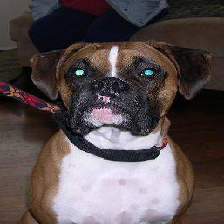

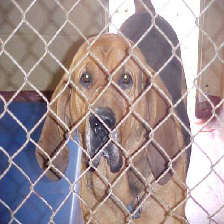

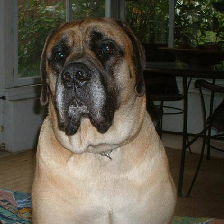

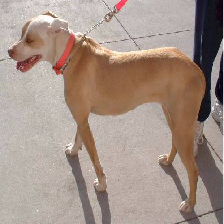

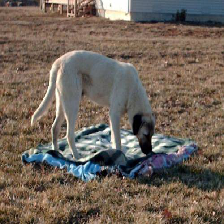



Input shape: (5, 224, 224, 3)
Input dtype: float32
Input data length number of images: 5

Neo transposed Input shape: (5, 3, 224, 224)
Neo transposed Input dtype: <dtype: 'float32'>
Neo transposed Input data length number of images: 5
Saving input tensor to file: preprocessed_images_1626290297.7991986.input

Uploading saved input tensor to DEMO-Sagemaker-Edge/iot in S3 bucket sagemaker-us-east-1-447791303113 as: preprocessed_images_1626290297.7991986.input...


Invoking predict() via Pelion Edge to process new batch of images from: ./images_2...

Invoking Prediction on Pelion Edge with Sagemaker. Model: keras-resnet50-image-recognizer Input Tensor: s3:///preprocessed_images_1626290297.7991986.input Output Tensor: s3:///resnet50-predicted.data

PelionSageAPI (POST): Url: https://api.us-east-1.mbedcloud.com/v2/device-requests/017a415e4fb83230f97c93d800300000?async-id=37387568-e00d-44f6-9ff6-34ba3d6bfcbc Data: {'method': 'POST', 'uri': '/33311/0/5701', 'payload-b64': 'eyJqc29ucnBjIjogIj

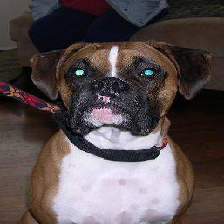

Predicted Image Contents: "boxer" Confidence: 91.511%



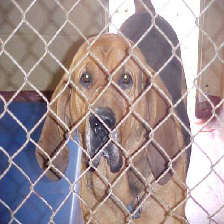

Predicted Image Contents: "bloodhound" Confidence: 99.534%



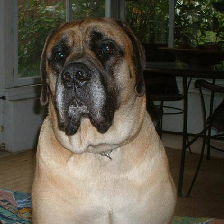

Predicted Image Contents: "bull_mastiff" Confidence: 99.417%



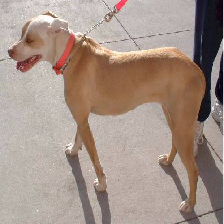

Predicted Image Contents: "boxer" Confidence: 47.072%



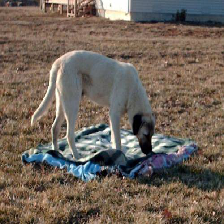

Predicted Image Contents: "borzoi" Confidence: 53.867%



In [57]:
# Load the new inputs
# Input images directory in our notebook...
image_paths = './images_2'

print("")
print("Loading up a new batch of images from: " + image_paths + "...")

# collect and prepare our images to analyze
print("")
print("Collecting images from: " + str(image_paths))
my_image_list = [os.path.join(image_paths,filename) for filename in os.listdir(image_paths) if os.path.isfile(image_paths + '/' + filename)]
my_image_list_length = len(my_image_list)

print("")
print("Input Image Files: " + json.dumps(my_image_list))

# read in the batch of images... then, preprocess_input() is ResNet50 specific
print("")
print("Pre-processing input image files...")
image_data = my_notebook.read_image_batch(my_image_list, image_size_h, image_size_w)
preprocessed_images_list = preprocess_input(image_data['array'])

# Display our initial images
print("")
print("Displaying Input Images:")
my_notebook.display_images(image_data['img'])

#
# Neo Sagemaker likes NCHW shapes for Keras models. 
# Our image set is in NHWC...
#
print("")
print("Input shape: " + str(preprocessed_images_list.shape))
print("Input dtype: " + str(preprocessed_images_list.dtype))
print("Input data length number of images: " + str(len(preprocessed_images_list)))

# ...so transpose() to NCHW format...  we have to do this because Neo requires a NCHW layer...
preprocessed_images_list = tf.transpose(preprocessed_images_list,[0, 3, 1, 2])

# Neo-compatible input tensor shape now!
print("")
print("Neo transposed Input shape: " + str(preprocessed_images_list.shape))
print("Neo transposed Input dtype: " + str(preprocessed_images_list.dtype))
print("Neo transposed Input data length number of images: " + str(len(preprocessed_images_list)))

# Save the preprocessed images, as the input tensor, to a single input file in S3
input_data_filename = 'preprocessed_images_' + str(time.time()) + '.input'
my_notebook.save_input_tensor_to_s3(preprocessed_images_list,input_data_filename)

# Now we invoke predict() again on the edge gw with the new batch...
print("")
print("Invoking predict() via Pelion Edge to process new batch of images from: " + image_paths + "...")
print("")

# Invoke the prediction with our input image data via Pelion using the S3 URLs for input and outputs...
input_tensor_s3 = 's3:///' + input_data_filename
output_tensor_s3 = 's3:///' + model_basename + '-predicted.data'
print("Invoking Prediction on Pelion Edge with Sagemaker. Model: " + model_name + " Input Tensor: " + input_tensor_s3 + " Output Tensor: " + output_tensor_s3)
print("")
my_notebook.pelion_api.pelion_predict(model_name, input_tensor_s3, output_tensor_s3)

# Poll every 5 sec to look for the predict() completion....
while True:
    print('Predicting...')
    is_running = my_notebook.pelion_api.pelion_cmd_is_running("predict");
    if is_running == False:
        print("")
        print('Prediction Completed!')
        print("")
        break
    time.sleep(5)
    
# Now get the prediction result
prediction_result = my_notebook.pelion_api.pelion_last_cmd_result();
if 'details' in prediction_result:
    if 'output' in prediction_result['details']:
        print("")
        print("Prediction Results:")
        print(prediction_result)
        
# Lastly we interpret the new prediction results
print("")
print("Decoding the prediction results from the new batch of images in: " + image_paths + "...")
print("")

# Prediction results tensor filename in our notebook
output_tensor_local_nb_filename = model_basename + '-prediction-output.tensor'

# Read the output tensor from S3 and deposit a copy of the output into the notebook. our output tensor should be float32 for Resnet50...
output_tensor = my_notebook.get_output_tensor(prediction_result['details']['output'][0]['url'], output_tensor_local_nb_filename, np.float32)

# Decode the Resnet50 prediction results
print("")
print("Decoding ResNet50 Imagenet-trained Prediction results...")
most_likely_labels = my_notebook.decode_resnet50_predictions(output_tensor, top=1, class_list_path=resnet50_class_list_path)

# Display the images, annotated with the predictions
print("")
print("Displaying prediction results...")
my_notebook.display_images(image_data['img'],most_likely_labels)

... and lets not forget the cat-lovers... lets try some predictions on cat pictures...


Loading up a new batch of images from: ./images_3...


Input Image Files: ["./images_3/cat.4645.jpg", "./images_3/cat.4667.jpg", "./images_3/cat.4646.jpg", "./images_3/cat.4668.jpg", "./images_3/cat.4644.jpg"]

Pre-processing input image files...
Displaying Input Images:


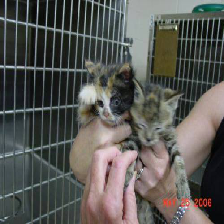

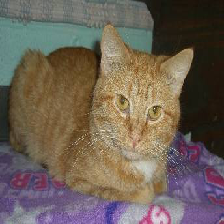

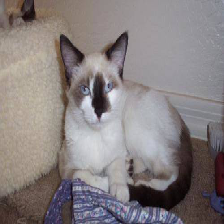

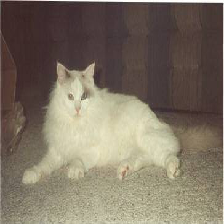

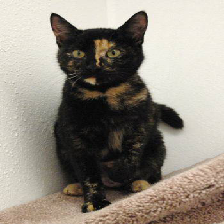



Input shape: (5, 224, 224, 3)
Input dtype: float32
Input data length number of images: 5

Neo transposed Input shape: (5, 3, 224, 224)
Neo transposed Input dtype: <dtype: 'float32'>
Neo transposed Input data length number of images: 5
Saving input tensor to file: preprocessed_images_1626290228.7389145.input

Uploading saved input tensor to DEMO-Sagemaker-Edge/iot in S3 bucket sagemaker-us-east-1-447791303113 as: preprocessed_images_1626290228.7389145.input...


Invoking predict() via Pelion Edge to process new batch of images from: ./images_3...

Invoking Prediction on Pelion Edge with Sagemaker. Model: keras-resnet50-image-recognizer Input Tensor: s3:///preprocessed_images_1626290228.7389145.input Output Tensor: s3:///resnet50-predicted.data

PelionSageAPI (POST): Url: https://api.us-east-1.mbedcloud.com/v2/device-requests/017a415e4fb83230f97c93d800300000?async-id=a2ab19aa-2979-4383-b5fa-bb3f6e8213e3 Data: {'method': 'POST', 'uri': '/33311/0/5701', 'payload-b64': 'eyJqc29ucnBjIjogIj

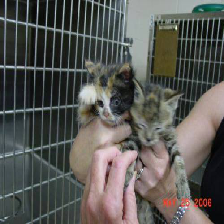

Predicted Image Contents: "marmoset" Confidence: 82.511%



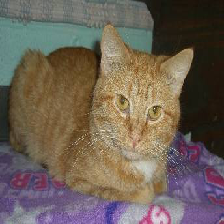

Predicted Image Contents: "tiger_cat" Confidence: 24.056%



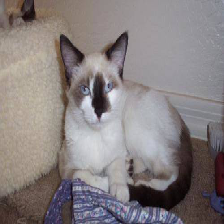

Predicted Image Contents: "Siamese_cat" Confidence: 99.906%



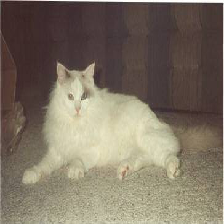

Predicted Image Contents: "Samoyed" Confidence: 60.773%



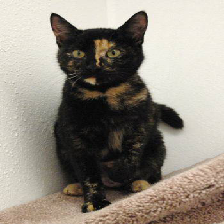

Predicted Image Contents: "tabby" Confidence: 28.269%



In [56]:
# Load the new inputs
# Input images directory in our notebook...
image_paths = './images_3'

print("")
print("Loading up a new batch of images from: " + image_paths + "...")

# collect and prepare our images to analyze
print("")
print("Collecting images from: " + str(image_paths))
my_image_list = [os.path.join(image_paths,filename) for filename in os.listdir(image_paths) if os.path.isfile(image_paths + '/' + filename)]
my_image_list_length = len(my_image_list)

print("")
print("Input Image Files: " + json.dumps(my_image_list))

# read in the batch of images... then, preprocess_input() is ResNet50 specific
print("")
print("Pre-processing input image files...")
image_data = my_notebook.read_image_batch(my_image_list, image_size_h, image_size_w)
preprocessed_images_list = preprocess_input(image_data['array'])

# Display our initial images
print("")
print("Displaying Input Images:")
my_notebook.display_images(image_data['img'])

#
# Neo Sagemaker likes NCHW shapes for Keras models. 
# Our image set is in NHWC...
#
print("")
print("Input shape: " + str(preprocessed_images_list.shape))
print("Input dtype: " + str(preprocessed_images_list.dtype))
print("Input data length number of images: " + str(len(preprocessed_images_list)))

# ...so transpose() to NCHW format...  we have to do this because Neo requires a NCHW layer...
preprocessed_images_list = tf.transpose(preprocessed_images_list,[0, 3, 1, 2])

# Neo-compatible input tensor shape now!
print("")
print("Neo transposed Input shape: " + str(preprocessed_images_list.shape))
print("Neo transposed Input dtype: " + str(preprocessed_images_list.dtype))
print("Neo transposed Input data length number of images: " + str(len(preprocessed_images_list)))

# Save the preprocessed images, as the input tensor, to a single input file in S3
input_data_filename = 'preprocessed_images_' + str(time.time()) + '.input'
my_notebook.save_input_tensor_to_s3(preprocessed_images_list,input_data_filename)

# Now we invoke predict() again on the edge gw with the new batch...
print("")
print("Invoking predict() via Pelion Edge to process new batch of images from: " + image_paths + "...")
print("")

# Invoke the prediction with our input image data via Pelion using the S3 URLs for input and outputs...
input_tensor_s3 = 's3:///' + input_data_filename
output_tensor_s3 = 's3:///' + model_basename + '-predicted.data'
print("Invoking Prediction on Pelion Edge with Sagemaker. Model: " + model_name + " Input Tensor: " + input_tensor_s3 + " Output Tensor: " + output_tensor_s3)
print("")
my_notebook.pelion_api.pelion_predict(model_name, input_tensor_s3, output_tensor_s3)

# Poll every 5 sec to look for the predict() completion....
while True:
    print('Predicting...')
    is_running = my_notebook.pelion_api.pelion_cmd_is_running("predict");
    if is_running == False:
        print("")
        print('Prediction Completed!')
        print("")
        break
    time.sleep(5)
    
# Now get the prediction result
prediction_result = my_notebook.pelion_api.pelion_last_cmd_result();
if 'details' in prediction_result:
    if 'output' in prediction_result['details']:
        print("")
        print("Prediction Results:")
        print(prediction_result)
        
# Lastly we interpret the new prediction results
print("")
print("Decoding the prediction results from the new batch of images in: " + image_paths + "...")
print("")

# Prediction results tensor filename in our notebook
output_tensor_local_nb_filename = model_basename + '-prediction-output.tensor'

# Read the output tensor from S3 and deposit a copy of the output into the notebook. our output tensor should be float32 for Resnet50...
output_tensor = my_notebook.get_output_tensor(prediction_result['details']['output'][0]['url'], output_tensor_local_nb_filename, np.float32)

# Decode the Resnet50 prediction results
print("")
print("Decoding ResNet50 Imagenet-trained Prediction results...")
most_likely_labels = my_notebook.decode_resnet50_predictions(output_tensor, top=1, class_list_path=resnet50_class_list_path)

# Display the images, annotated with the predictions
print("")
print("Displaying prediction results...")
my_notebook.display_images(image_data['img'],most_likely_labels)

Here I can run the model within the notebook itself to confirm that I get the same result as with the compiled version on my xavier board:

In [ ]:
#
# Because we are NOT running the model via Neo here, and because Resnet50 is channels-last by default,
# we need to re-transpose the images back to channel-last...
#
output_original_shaped_list = tf.transpose(preprocessed_images_list, [0, 2, 3, 1])
print("Input Tensor: (reshaped) Shape: " + str(output_original_shaped_list.shape) + " Type: " + str(output_original_shaped_list.dtype))

# Perform a prediction directly in the notebook with our model...
direct_prediction_results = resnet50_model.predict(output_original_shaped_list)

# Display the prediction results tensor info...
print("Output Tensor - Shape: " + json.dumps(direct_prediction_results.shape) + " Type: " + str(direct_prediction_results.dtype))

# Decode the predictions in the exact same way as we did with Neo...
print("")
print("Decoding ResNet50 Imagenet-trained Prediction results...")
most_likely_labels = my_notebook.decode_resnet50_predictions(direct_prediction_results, top=1, class_list_path=resnet50_class_list_path)

# Display the image results
print("")
print("Displaying prediction results...")
my_notebook.display_images(image_data['img'],most_likely_labels)